Epoch 1/50


c:\Users\tusha\anaconda3\envs\tensorflow\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0146 - mean_absolute_error: 0.0986 - val_loss: 0.0107 - val_mean_absolute_error: 0.0778
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0100 - mean_absolute_error: 0.0810 - val_loss: 0.0105 - val_mean_absolute_error: 0.0761
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0068 - mean_absolute_error: 0.0669 - val_loss: 0.0085 - val_mean_absolute_error: 0.0751
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0062 - mean_absolute_error: 0.0643 - val_loss: 0.0078 - val_mean_absolute_error: 0.0701
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 0.0130 - val_mean_absolute_error: 0.0889
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0047 - mean_absolute_error: 0.0557 - val_loss: 0.0072 - val_mean_absolute_error: 0.0667
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0070 - 

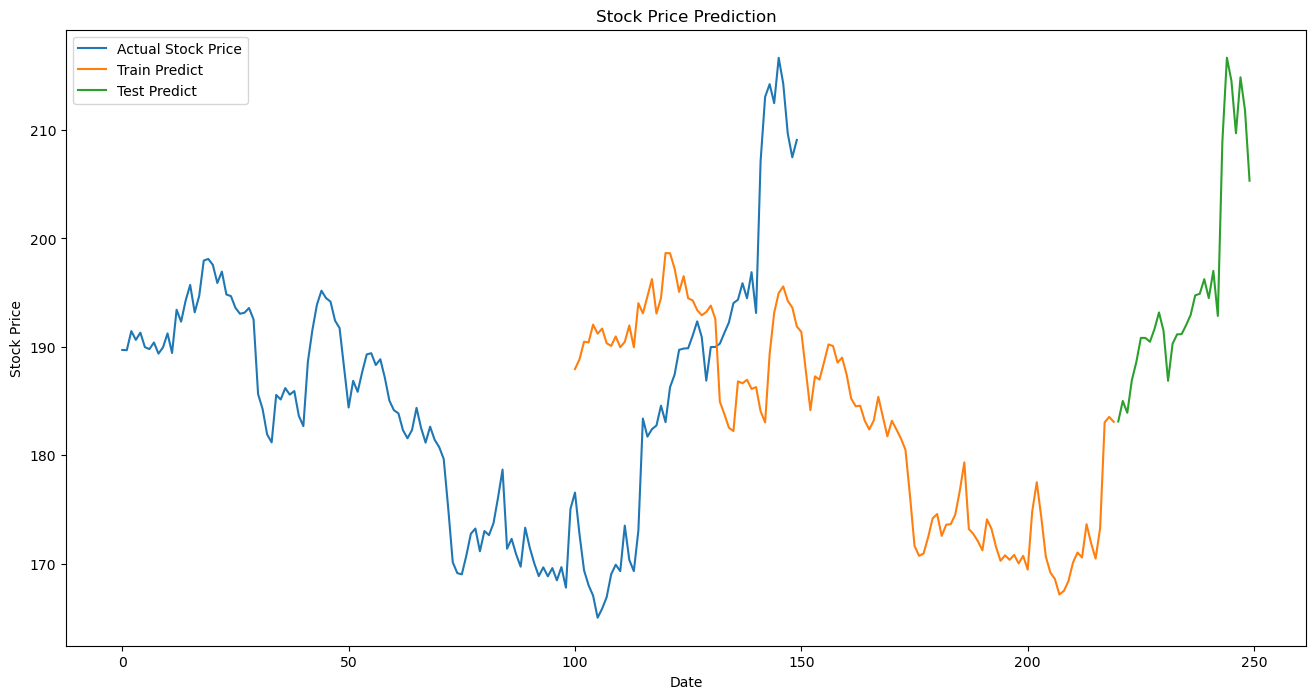

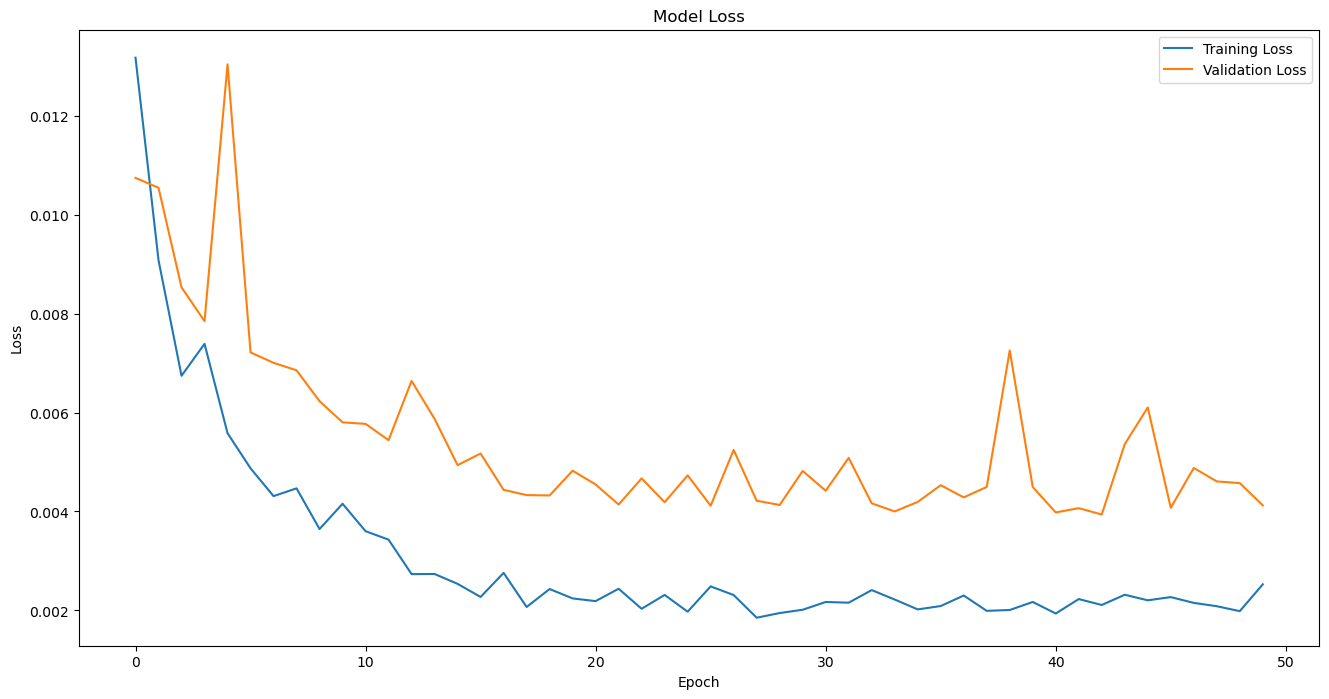

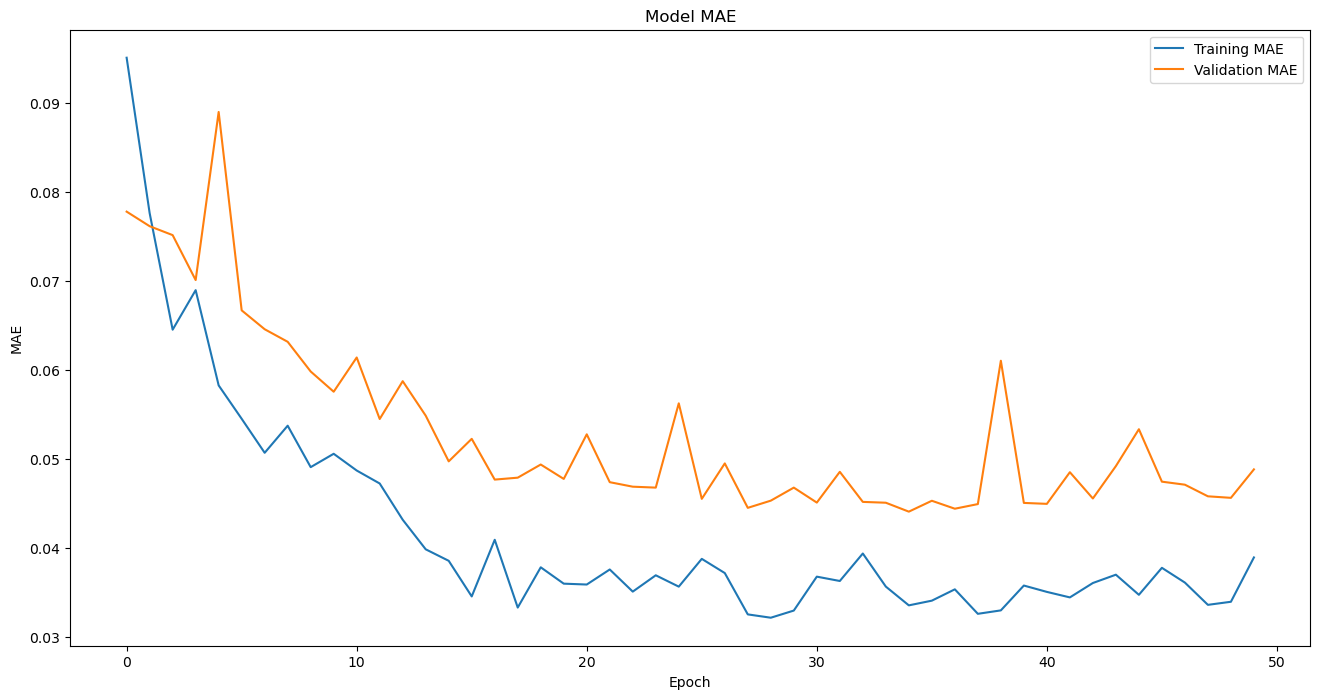

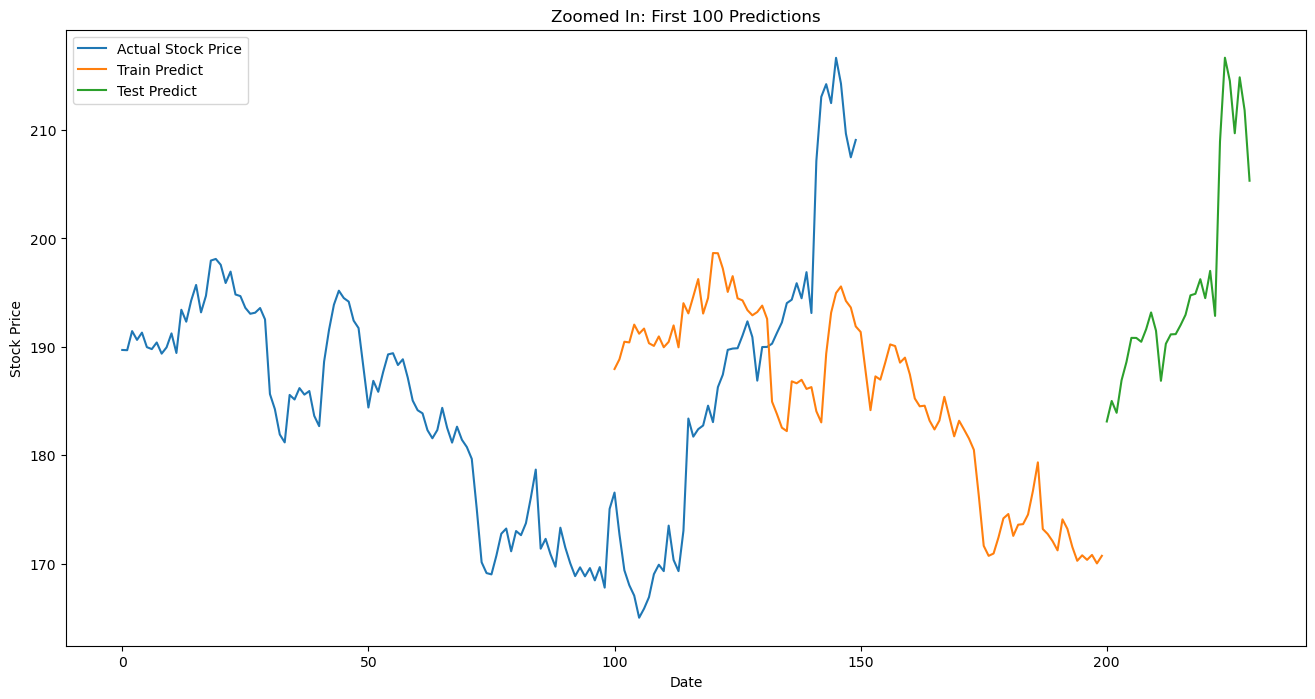

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
import os

# Load the dataset
data = pd.read_csv('AAPL.csv')

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step and create sequences
time_step = 100
X, y = create_sequences(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model and save training history
history = model.fit(X_train, y_train, batch_size=1, epochs=50, validation_split=0.2)

# Print training and validation loss and MAE
print(f"Training Loss: {history.history['loss'][-1]}")
print(f"Training MAE: {history.history['mean_absolute_error'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")
print(f"Validation MAE: {history.history['val_mean_absolute_error'][-1]}")

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
actual_prices = scaler.inverse_transform(scaled_data[time_step + 1:])

# Calculate MAE for the test set
mae = np.mean(np.abs(test_predict - actual_prices[:len(test_predict)]))
print(f"Test MAE: {mae}")

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(actual_prices, label='Actual Stock Price')
plt.plot(np.arange(time_step, len(train_predict) + time_step), train_predict, label='Train Predict')
plt.plot(np.arange(len(train_predict) + time_step, len(train_predict) + time_step + len(test_predict)), test_predict, label='Test Predict')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(16, 8))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Zoom into the first 100 predictions
plt.figure(figsize=(16, 8))
plt.plot(actual_prices[:200], label='Actual Stock Price')
plt.plot(np.arange(time_step, len(train_predict[:100]) + time_step), train_predict[:100], label='Train Predict')
plt.plot(np.arange(len(train_predict[:100]) + time_step, len(train_predict[:100]) + time_step + len(test_predict[:100])), test_predict[:100], label='Test Predict')
plt.title('Zoomed In: First 100 Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
